## DDIM

In [149]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from fastprogress.fastprogress import progress_bar
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler
from types import SimpleNamespace



import miniai.fastprogressfix
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import *

In [2]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
def_device

'cuda'

DDPM Scheduler from the diffusers library

In [3]:
# provide new unet to load model
# The last version had an overriden forward to call sample.
# Since we are now using the hugging face library we dont need to unwrap the sample 
class UNet(UNet2DModel): pass

model = torch.load('models/fashion_ddpm3_25.pkl').cuda()

In [4]:
sched = DDPMScheduler(beta_end=0.01)

This is the steps required in the loop

In [5]:
x_t = torch.randn((32,1,32,32)).cuda() # create sample data (noise)

t = 999 # timestep
t_batch = torch.full((len(x_t),), t, device=x_t.device, dtype=torch.long) # tensor full of timestep 999
with torch.no_grad(): noise = model(x_t, t_batch).sample # pass noise and timestep into model, returns predicted noise
res = sched.step(noise, t, x_t) # use the scheduler to remove predicted noise and add noise back depending on timestep
res.prev_sample.shape

torch.Size([32, 1, 32, 32])

In [6]:
t_batch

tensor([999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999], device='cuda:0')

Now run above step in a loop working through timesteps

In [114]:
%%time

sz = (256,1,32,32)
x_t = torch.randn(sz).cuda()
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())


CPU times: user 3min 7s, sys: 269 ms, total: 3min 8s
Wall time: 3min 8s


In [115]:
s1 = preds[-1]
s = s1.clamp(-0.5,0.5)*2
s1.min(), s1.max(), s1.mean(), s1.std(), "S2", s.min(), s.max(), s.mean(), s.std()


(tensor(-0.5300),
 tensor(0.6599),
 tensor(-0.2676),
 tensor(0.3373),
 'S2',
 tensor(-1.),
 tensor(1.),
 tensor(-0.5347),
 tensor(0.6739))

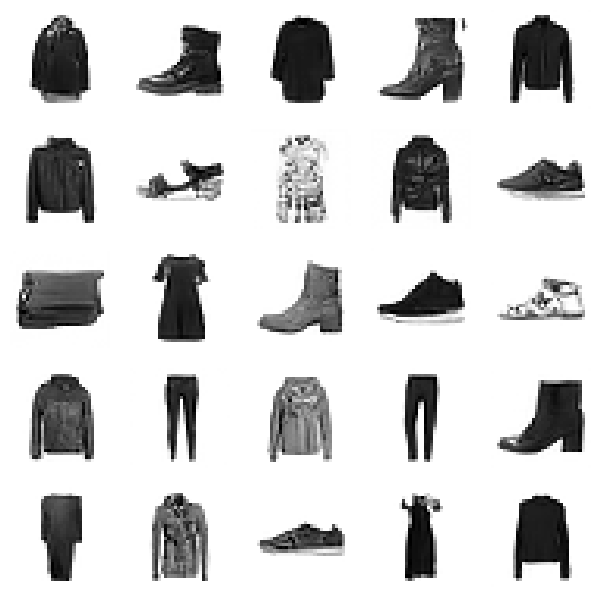

In [116]:
show_images(s[:25], imsize=1.5)


In [117]:
cmodel = torch.load('models/data_aug3.pkl')
del(cmodel[8])
del(cmodel[7])


In [130]:
import importlib
importlib.reload(miniai.fid)
from miniai.fid import *

In [131]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

tds.shape


test
torch.Size([10000, 512])


{'train': (60000, 2), 'test': (10000, 2)}

In [132]:
s.shape, xb.shape

(torch.Size([256, 1, 32, 32]), torch.Size([256, 1, 32, 32]))

(7656.546875, 3209.945556640625)

141.826416015625

In [142]:
ie.fid(s) ,ie.fid2(s), ie.kid(s)

torch.Size([256, 512])
originals..


torch.Size([256, 512])


(76.04833984375, 63.74462080176129, 0.24859173595905304)

(-7.7542724609375, 1.077541470527649)

107.87841796875

In [143]:
ie.fid(xb) ,ie.fid2(xb), ie.kid(xb)


torch.Size([256, 512])
originals..


torch.Size([256, 512])


(42.9775390625, 63.83868048719803, -0.18700091540813446)

In [137]:
clean_mem()

In [124]:
### DDIM

DDIM Scheduler from the diffusers library

In [125]:
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(333)

In [138]:
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).cuda()
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds


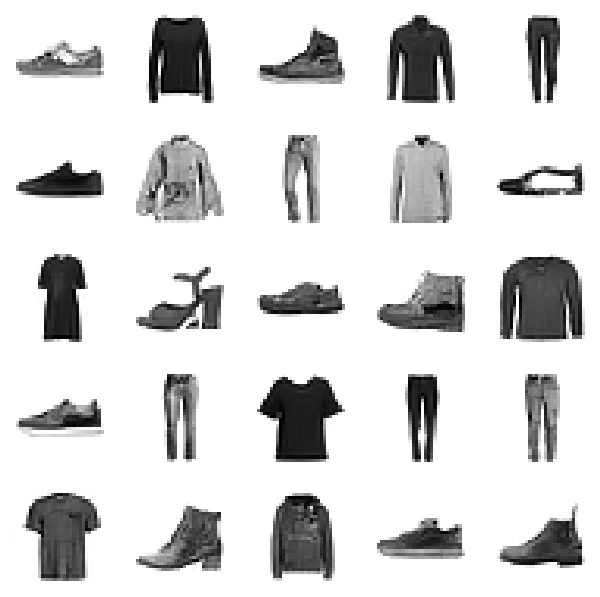

In [139]:
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
show_images(s[:25], imsize=1.5)


In [144]:
ie.fid(s) ,ie.fid2(s), ie.kid(s)

torch.Size([256, 512])
originals..


torch.Size([256, 512])


(76.04833984375, 63.74462080176129, 0.24859173595905304)

In [145]:
ie.fid(xb) ,ie.fid2(xb), ie.kid(xb)

torch.Size([256, 512])
originals..


torch.Size([256, 512])


(42.9775390625, 63.83868048719803, -0.18700091540813446)

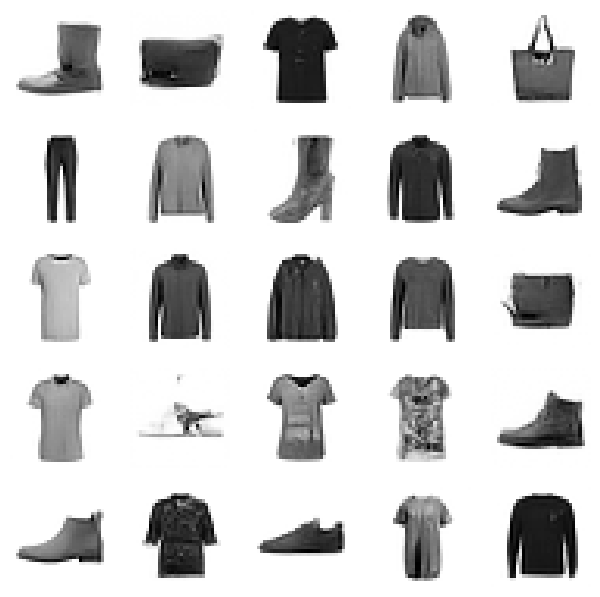

In [146]:
sched.set_timesteps(20)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
show_images(s[:25], imsize=1.5)

In [147]:
ie.fid(s) ,ie.fid2(s), ie.kid(s)

torch.Size([256, 512])
originals..
torch.Size([256, 512])


(100.251953125, 65.26907248015269, 0.8560536503791809)

### Implementing DDIM From Scratch

In [162]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())


n_steps=1000
sc = linear_sched(betamax=0.01, n_steps=n_steps)
abar = sc.abar
     

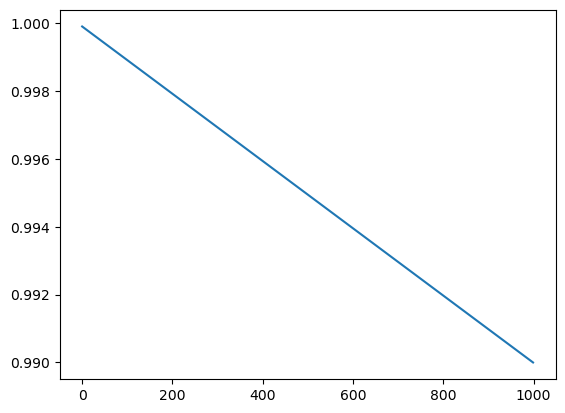

In [163]:
plt.plot(sc.a)

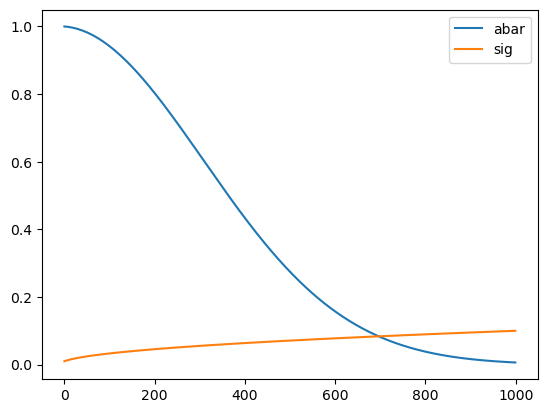

In [164]:
plt.plot(sc.abar)
plt.plot(sc.sig)
plt.legend(["abar", "sig"])

In [165]:
def ddim_step(x_t, t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta):
    vari = ((bbar_t1/bbar_t) * (1-abar_t/abar_t1))
    sig = vari.sqrt()*eta
    x_0_hat = ((x_t-bbar_t.sqrt()*noise) / abar_t.sqrt())
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    if t>0: x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_t


In [166]:
@torch.no_grad()
def sample(f, model, sz, n_steps, skips=1, eta=1.):
    tsteps = list(reversed(range(0, n_steps, skips)))
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(progress_bar(tsteps)):
        abar_t1 = abar[tsteps[i+1]] if t > 0 else torch.tensor(1)
        noise = model(x_t,t).sample
        x_t = f(x_t, t, noise, abar[t], abar_t1, 1-abar[t], 1-abar_t1, eta)
        preds.append(x_t.float().cpu())
    return preds


torch.Size([256, 512])
originals..
torch.Size([256, 512])


(64.279541015625, 63.50103303845611, 0.1404234617948532)

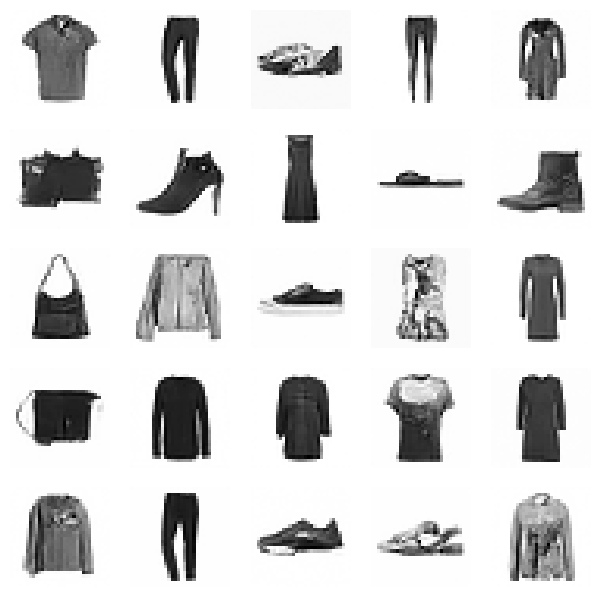

In [173]:
samples = sample(ddim_step, model, sz, 1000, 1)
s = (samples[-1]*2)#.clamp(-1,1)
show_images(s[:25], imsize=1.5)
ie.fid(s) ,ie.fid2(s), ie.kid(s)

torch.Size([256, 512])
originals..
torch.Size([256, 512])


(85.537109375, 65.42462933023553, 0.6308765411376953)

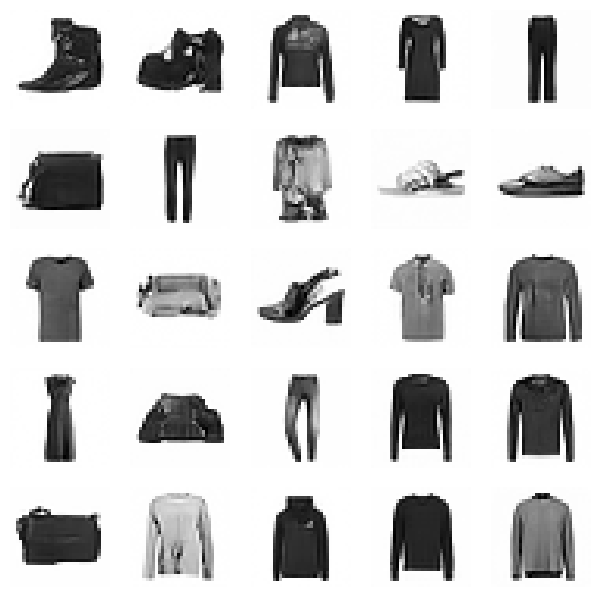

In [174]:
samples2 = sample(ddim_step, model, sz, 1000, 10)
s = (samples2[-1]*2)#.clamp(-1,1)
show_images(s[:25], imsize=1.5)
ie.fid(s) ,ie.fid2(s), ie.kid(s)